<a href="https://colab.research.google.com/github/simsekergun/Resolution/blob/main/ResolutionATTENTION256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics 
from sklearn.model_selection import train_test_split

In [2]:
!pip install gputil
!pip install psutil
!pip install humanize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=1ab7f2d996ae355ea54324f938efbe9be2b53cdba5a0c24486cdd1024cec3a50
  Stored in directory: /root/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!rm -rf Resolution
!git clone https://github.com/simsekergun/Resolution.git

Cloning into 'Resolution'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 62 (delta 2), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (62/62), 11.58 MiB | 5.48 MiB/s, done.


In [4]:
ls

Resolution/  sample_data/


In [5]:
ls ./Resolution/.

Attention.py                df_r.pt          README.md
Create_pt_resolution.ipynb  Es_measured.csv  ResolutionATTENTION256.ipynb
df_m.pt                     Es_real.csv      ResolutionFCNN.ipynb


In [6]:
%run ./Resolution/Attention.py

/content/Resolution/Attention.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
m_Dataset = torch.load('./Resolution/df_m.pt')
m_Dataset.shape

torch.Size([2330, 110])

In [8]:
r_Dataset = torch.load('./Resolution/df_r.pt')
r_Dataset.shape

torch.Size([2330, 100])

In [9]:
dataset = torch.cat((m_Dataset, r_Dataset), 1)
dataset.shape

torch.Size([2330, 210])

In [10]:
class Get_Dataset(Dataset):
    # ngap determines the gap between training and test
    # datasets in terms for frequency (e.g f_gap = ngap*0.5 THz)
    def __init__(self, dataset, n=110, input_dim = 10):
        self.dataset = dataset
        self.n = n
        self.input_dim = input_dim        

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        x = self.dataset[:, :self.n].reshape(-1, self.input_dim, self.n//self.input_dim)        
        y = self.dataset[:, self.n:]       # Creating a frequency gap between feature and target
        x = x[idx, :, :]
        y = y[idx]
        return x, y

In [11]:
# variables
eta = 0.001            # learning rate
step_size = 10         # Period of learning rate decay, see torch.optim.lr_scheduler.StepLR
gamma = 0.5            # Multiplicative factor of learning rate decay. Default: 0.1
epoch_no = 200         # number of epochs that will be used in training
activation_f='ReLU'
att_active_f='ReLU'
optimizer_f = torch.optim.AdamW
n_freq_training = 110   # number of frequencies will be used for training
input_dim=11     # attention mechanism input dimension
num_neurons=256  # number of neurons to be used in the NN
output_dim=100
T_length=n_freq_training//input_dim
n_training_feature = n_freq_training
n_test = 466

In [12]:
generator1 = torch.Generator().manual_seed(42)

train_data, test_data = torch.utils.data.random_split(Get_Dataset(dataset=dataset,n=110,input_dim=input_dim), (dataset.shape[0]-n_test, n_test), generator=generator1) 

In [13]:
# Loading the data through DataLoader:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
# Defining the attention context by the additive attention
model = SmarterAttentionNet(T_length=T_length, input_dim=input_dim, num_neurons=num_neurons, output_dim=output_dim, activation=activation_f , att_active=att_active_f)
loss_func = nn.MSELoss()
optimizer = optimizer_f(model.parameters(), lr=eta)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [15]:
# Training the model:
start = time.time()
results = train_network_reg(model, loss_func, train_loader, test_loader=test_loader, epochs=epoch_no, score_funcs={'R^2 score': r2_score}, device=device, optimizer=optimizer, lr_schedule=scheduler)
stop = time.time()


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Testing:   0%|          | 0/15 [00:00<?, ?it/s]

In [16]:
print('Training time: %s sec' %(stop-start))

Training time: 169.39405059814453 sec


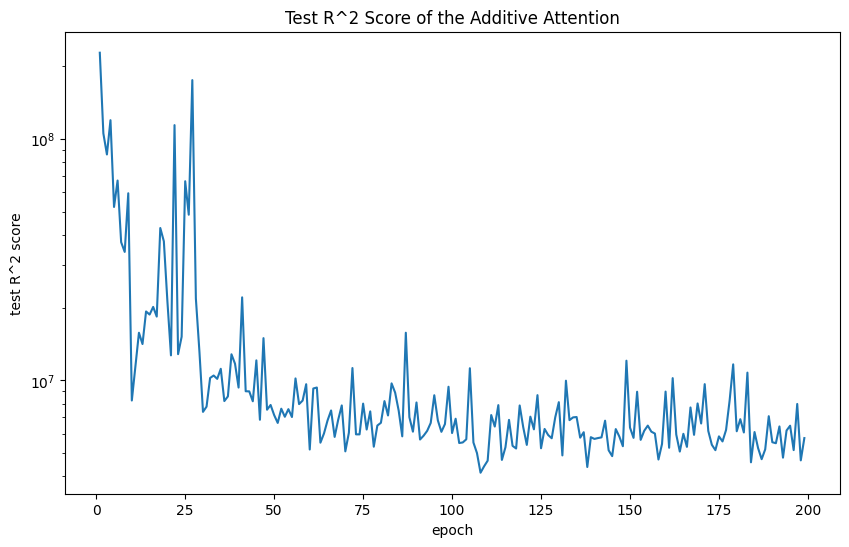

In [17]:
# Plotting the accuracy of the additive attention
sns.lineplot(x='epoch', y='test R^2 score', data=np.abs(results[1:]))
plt.title('Test R^2 Score of the Additive Attention')
plt.gcf().set_size_inches(10, 6)
plt.yscale('log')
plt.show()

In [18]:
def plot_results(model, test_data,device_num,position):
  sample_test_data = torch.tensor(np.array([np.array(test_data[device_num][0])]), dtype=torch.float32, device=device) 
  sample_test_dataT = torch.transpose(sample_test_data, 1, 2).to(device)
  y_true = np.array(test_data[device_num][1])

  with torch.no_grad():
    y_pred = model(sample_test_data).cpu().numpy()

  df = pd.DataFrame()
  df['Fr'] = pd.Series(position)
  df['y_true'] = pd.Series(y_true)
  df['y_pred'] = pd.Series(y_pred[0])
  df.plot(kind='line', x='Fr', y=['y_true', 'y_pred'], figsize=(8,4), title='Prediction vs Ground Truth for Device %d' %(device_num))
  plt.show()
  return

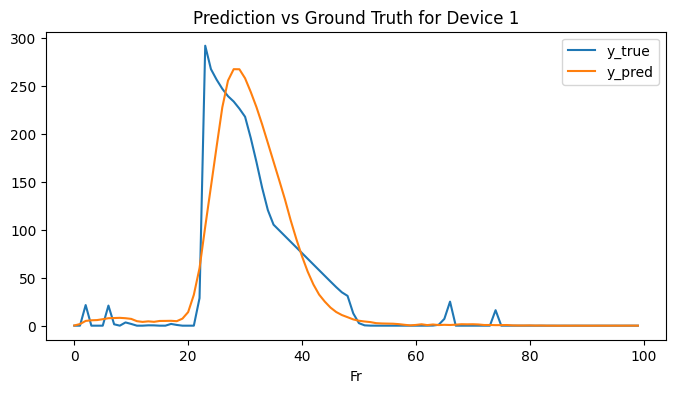

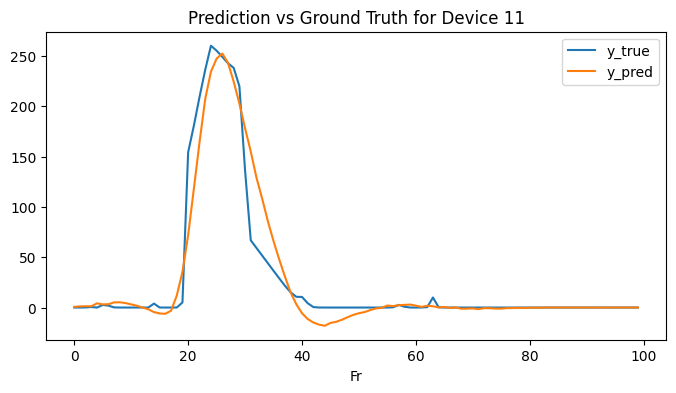

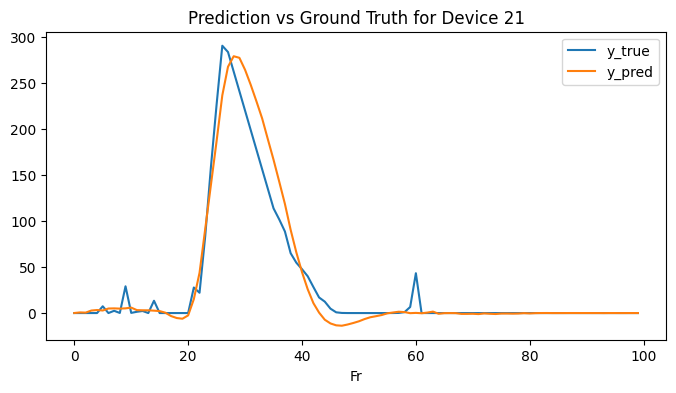

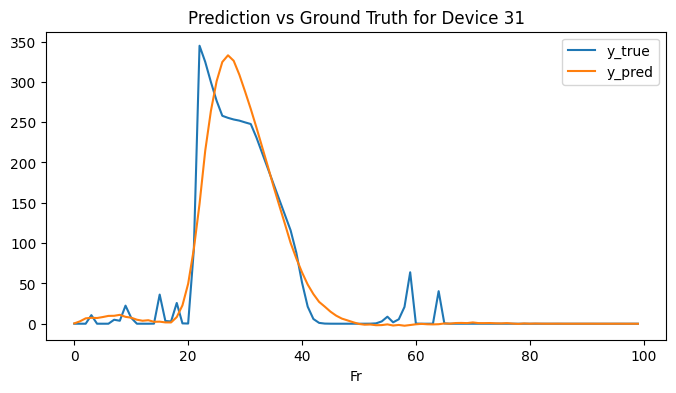

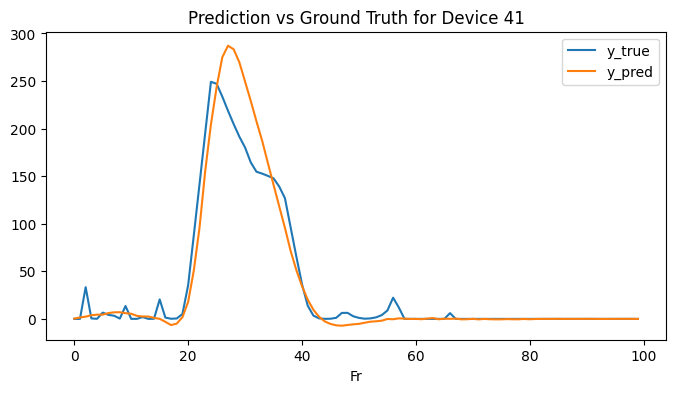

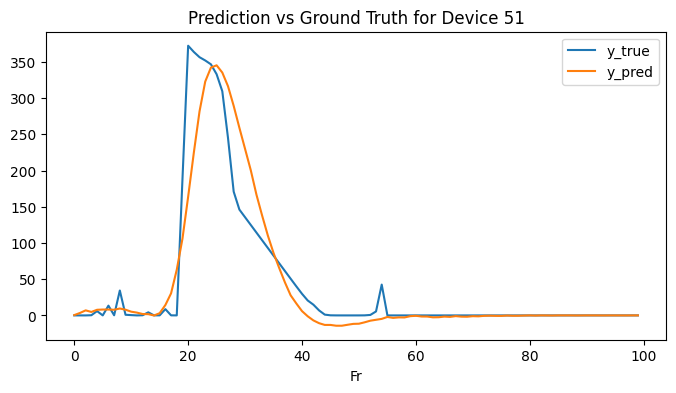

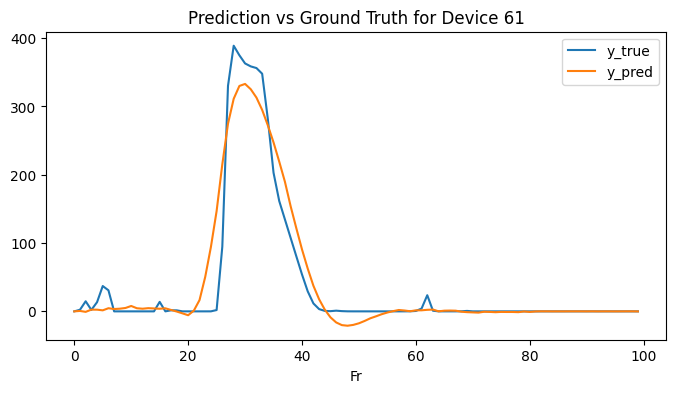

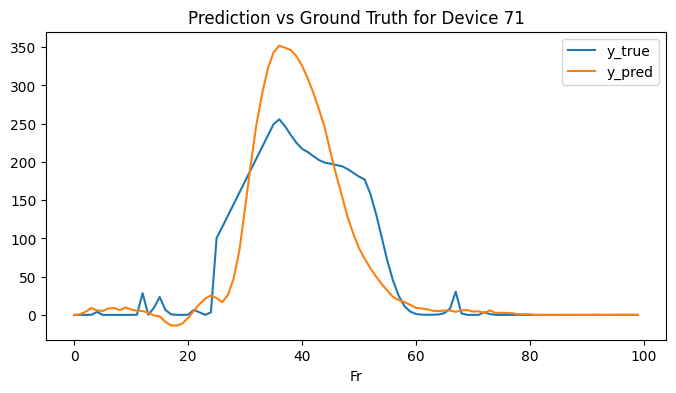

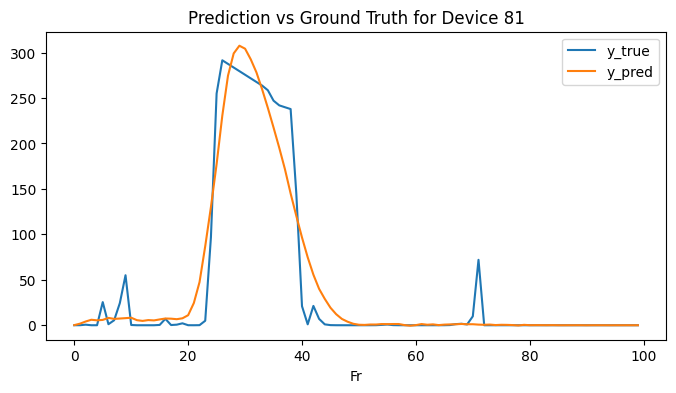

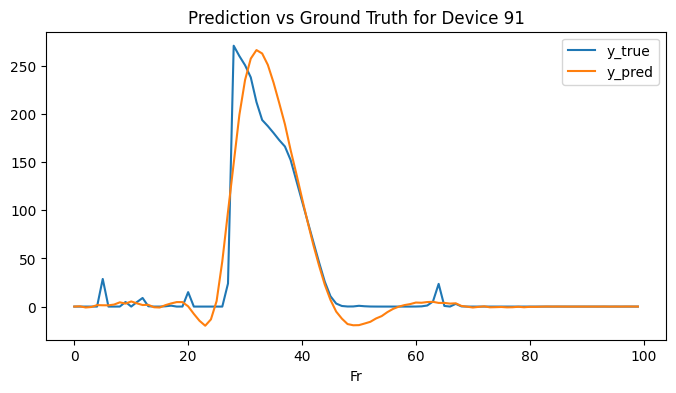

In [19]:
positions = np.arange(100)
for i in range(1,100,10):
    plot_results(model,test_data,i,positions)

In [20]:
def get_average_error(model, test_data,device_num):
  sample_test_data = torch.tensor(np.array([np.array(test_data[device_num][0])]), dtype=torch.float32, device=device) 
  sample_test_dataT = torch.transpose(sample_test_data, 1, 2).to(device)
  y_true = np.array(test_data[device_num][1])

  with torch.no_grad():
    y_pred = model(sample_test_data).cpu().numpy()

  yt = pd.Series(y_true)
  yp = pd.Series(y_pred[0])
  err = yt-yp
  mape = err.abs().mean()/yt.max()
  return mape

In [21]:
errors = np.zeros(n_test)
for i in range(0,n_test,1):
    errors[i]=get_average_error(model,test_data,i)
errors.mean()

0.048604439544319596

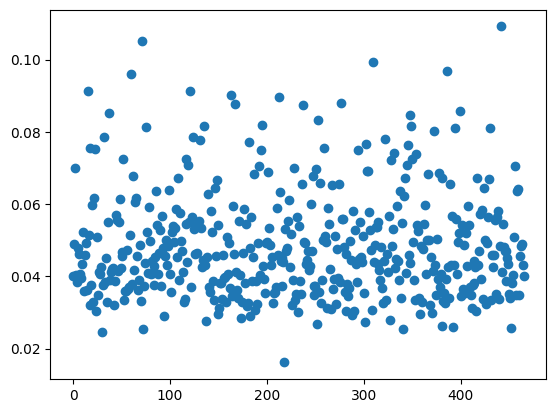

In [22]:
x = np.arange(n_test)
plt.scatter(x, errors)
plt.show()

In [23]:
def get_true_vs_pred(model, test_data,device_num):
  sample_test_data = torch.tensor(np.array([np.array(test_data[device_num][0])]), dtype=torch.float32, device=device) 
  sample_test_dataT = torch.transpose(sample_test_data, 1, 2).to(device)
  y_true = np.array(test_data[device_num][1])

  with torch.no_grad():
    y_pred = model(sample_test_data).cpu().numpy()

  mse = mean_squared_error(pd.Series(y_true), pd.Series(y_pred[0]))/pd.Series(y_true).max()
  return y_true, y_pred

In [24]:
y_trues = np.zeros((n_test,100))
y_preds = np.zeros((n_test,100))
for i in range(0,n_test,1):
  y_true, y_pred = get_true_vs_pred(model, test_data,i)
  y_trues[i,:] = y_true
  y_preds[i,:] = y_pred

In [25]:
df_ytrue = pd.DataFrame(y_trues)
df_ypred = pd.DataFrame(y_preds)

In [26]:
from google.colab import files
df_ytrue.to_csv('Attention_ytest.csv')
df_ypred.to_csv('Attention_ypred.csv')
files.download('Attention_ytest.csv')
files.download('Attention_ypred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>